In [1]:
import scanpy as sc
import pandas as pd

In [2]:
sc.settings.verbosity = 3  # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.settings.set_figure_params(dpi=80, facecolor="white")

In [3]:
counts_file = "data/5_annotation_res0.2_subclustered_counts.csv"
metadata_file = "data/5_annotation_res0.2_subclustered_metadata.csv"

In [4]:
counts = pd.read_csv(counts_file, index_col=0)
adata = sc.AnnData(counts.transpose())
adata

AnnData object with n_obs × n_vars = 26167 × 36601

In [5]:
# Load and add the metadata
metadata = pd.read_csv(metadata_file, index_col=0)
adata.obs = metadata
adata

AnnData object with n_obs × n_vars = 26167 × 36601
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'hash.ID', 'stimulation', 'tissue', 'nCount_ADT', 'nFeature_ADT', 'nCount_HTO', 'nFeature_HTO', 'percent.mt', 'percent.rb', 'RNA_snn_res.0.01', 'RNA_snn_res.0.04', 'RNA_snn_res.0.08', 'RNA_snn_res.0.1', 'RNA_snn_res.0.14', 'RNA_snn_res.0.18', 'RNA_snn_res.0.2', 'RNA_snn_res.0.3', 'seurat_clusters', 'initial_celltypes', 'CellType', 'CoarseCellType'

In [6]:
print('Number of unique gene names before calling var_names_make_unique =', len(pd.unique(adata.var_names)))
adata.var_names_make_unique()
print('Number of unique gene names after calling var_names_make_unique =', len(pd.unique(adata.var_names)))

Number of unique gene names before calling var_names_make_unique = 36601
Number of unique gene names after calling var_names_make_unique = 36601


normalizing counts per cell
    finished (0:00:14)


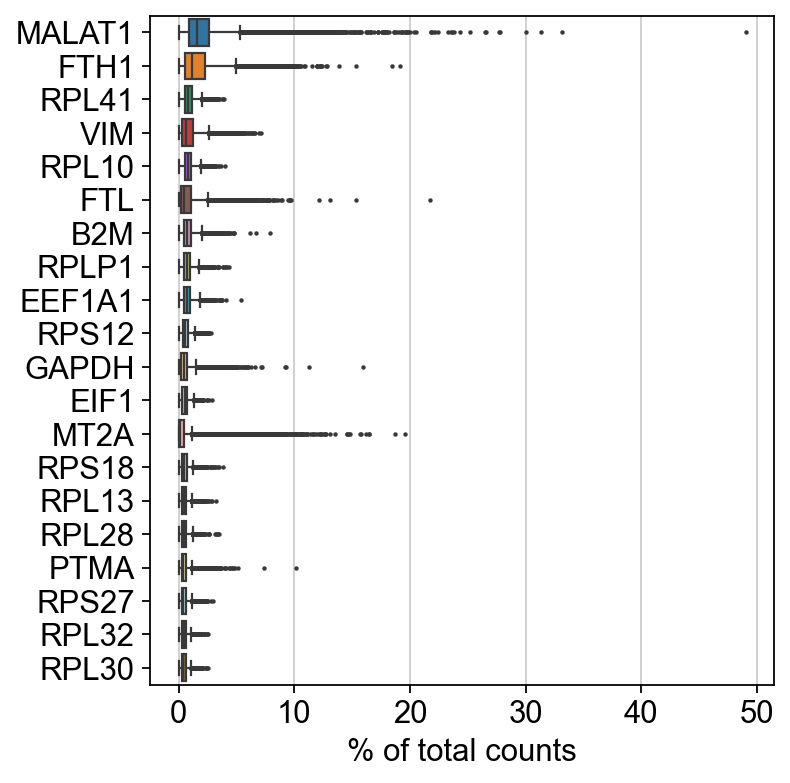

In [7]:
sc.pl.highest_expr_genes(adata, n_top=20)

In [8]:
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)

filtered out 104 cells that have less than 200 genes expressed
filtered out 10037 genes that are detected in less than 3 cells


In [9]:
# annotate the group of mitochondrial genes as "mt"
adata.var["mt"] = adata.var_names.str.startswith("MT-")
sc.pp.calculate_qc_metrics(
    adata, qc_vars=["mt"], percent_top=None, log1p=False, inplace=True
)

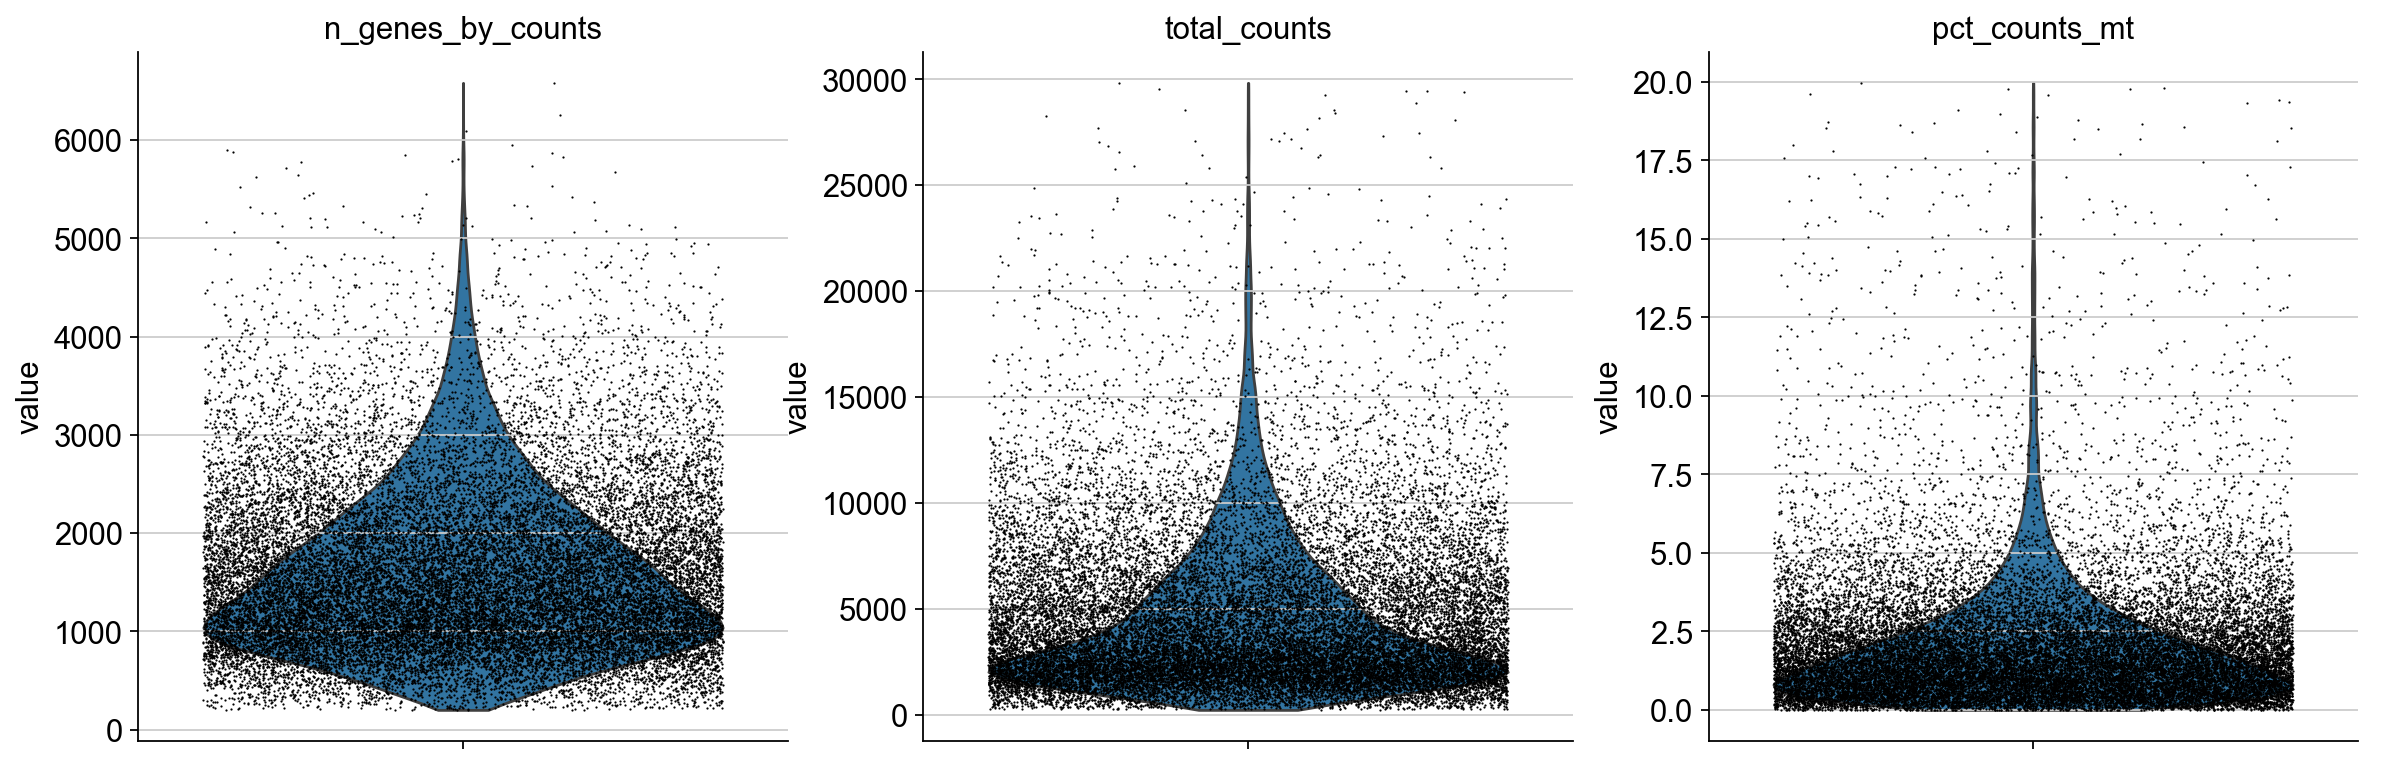

In [10]:
sc.pl.violin(
    adata,
    ["n_genes_by_counts", "total_counts", "pct_counts_mt"],
    jitter=0.4,
    multi_panel=True,
)

In [11]:
adata = adata[adata.obs.n_genes_by_counts < 2500, :]
adata = adata[adata.obs.pct_counts_mt < 5, :].copy()

In [12]:
sc.pp.normalize_total(adata, target_sum=1e4)

normalizing counts per cell
    finished (0:00:01)


In [13]:
sc.pp.log1p(adata)

In [14]:
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)

extracting highly variable genes


/Users/andres/miniconda3/envs/scanpy/lib/python3.11/site-packages/scanpy/preprocessing/_highly_variable_genes.py:226: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  disp_grouped = df.groupby("mean_bin")["dispersions"]


    finished (0:00:04)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


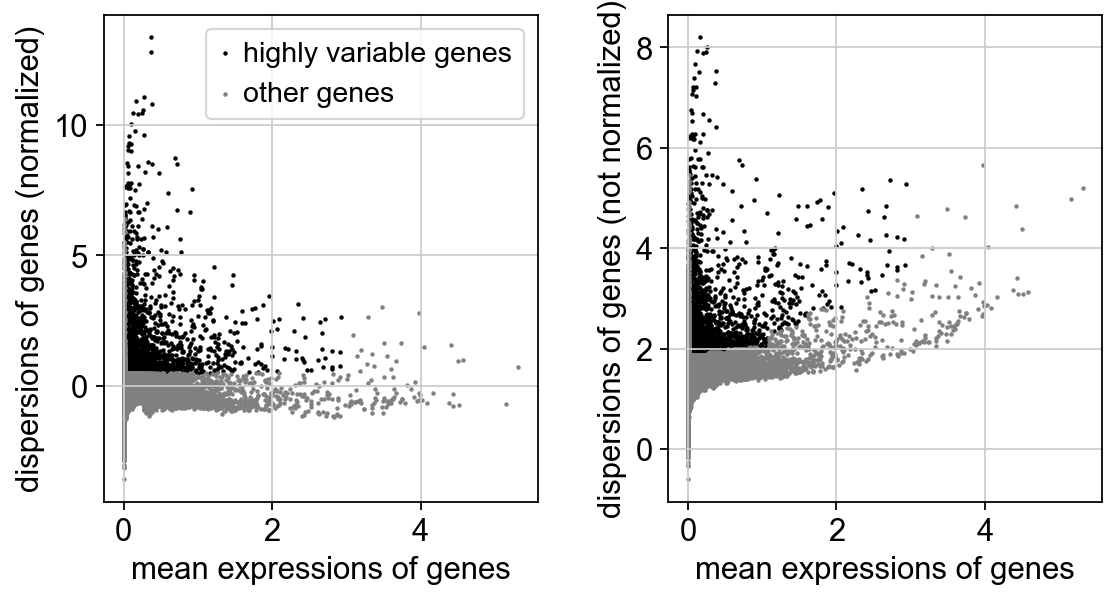

In [15]:
sc.pl.highly_variable_genes(adata)

In [16]:
adata.raw = adata

In [17]:
adata = adata[:, adata.var.highly_variable]

In [18]:
sc.pp.regress_out(adata, ["total_counts", "pct_counts_mt"])

regressing out ['total_counts', 'pct_counts_mt']
    finished (0:00:43)


In [19]:
sc.pp.scale(adata, max_value=10)

In [20]:
sc.tl.pca(adata, svd_solver="arpack")

computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:03)


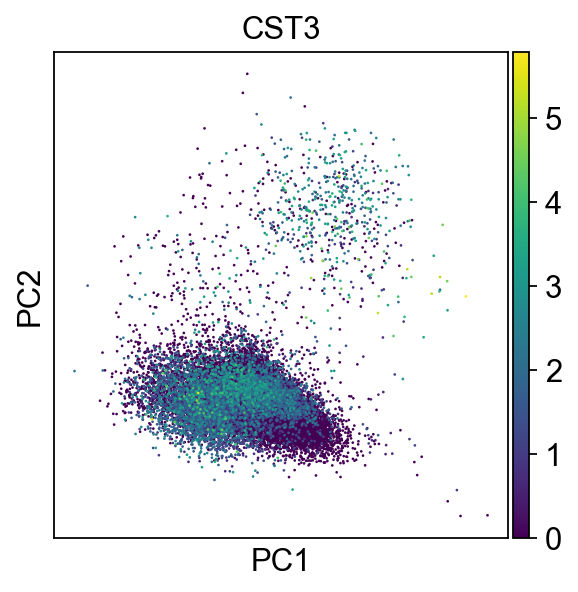

In [21]:
sc.pl.pca(adata, color="CST3")

In [22]:
adata

AnnData object with n_obs × n_vars = 20632 × 2810
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'hash.ID', 'stimulation', 'tissue', 'nCount_ADT', 'nFeature_ADT', 'nCount_HTO', 'nFeature_HTO', 'percent.mt', 'percent.rb', 'RNA_snn_res.0.01', 'RNA_snn_res.0.04', 'RNA_snn_res.0.08', 'RNA_snn_res.0.1', 'RNA_snn_res.0.14', 'RNA_snn_res.0.18', 'RNA_snn_res.0.2', 'RNA_snn_res.0.3', 'seurat_clusters', 'initial_celltypes', 'CellType', 'CoarseCellType', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'log1p', 'hvg', 'pca'
    obsm: 'X_pca'
    varm: 'PCs'

In [23]:
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=40)

computing neighbors
    using 'X_pca' with n_pcs = 40
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:14)


In [24]:
sc.tl.leiden(
    adata,
    resolution=0.7,
    random_state=0,
    n_iterations=-1,
    directed=False,
)

running Leiden clustering
    finished: found 17 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:01)


running PAGA
    finished: added
    'paga/connectivities', connectivities adjacency (adata.uns)
    'paga/connectivities_tree', connectivities subtree (adata.uns) (0:00:00)
--> added 'pos', the PAGA positions (adata.uns['paga'])


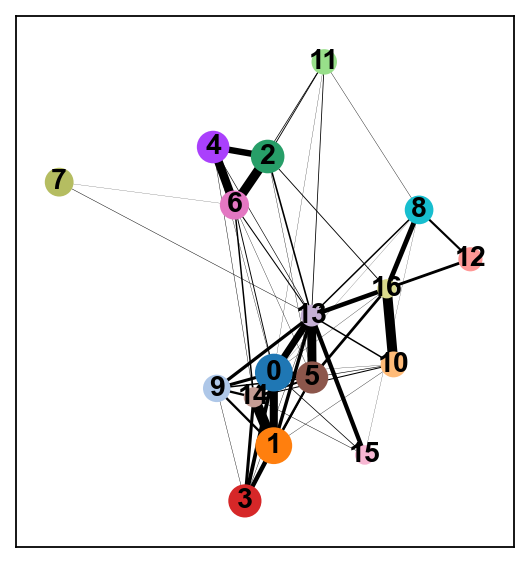

computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:07)


In [25]:
sc.tl.paga(adata)
sc.pl.paga(adata, plot=True)
sc.tl.umap(adata, init_pos='paga')

# sc.tl.umap(adata)

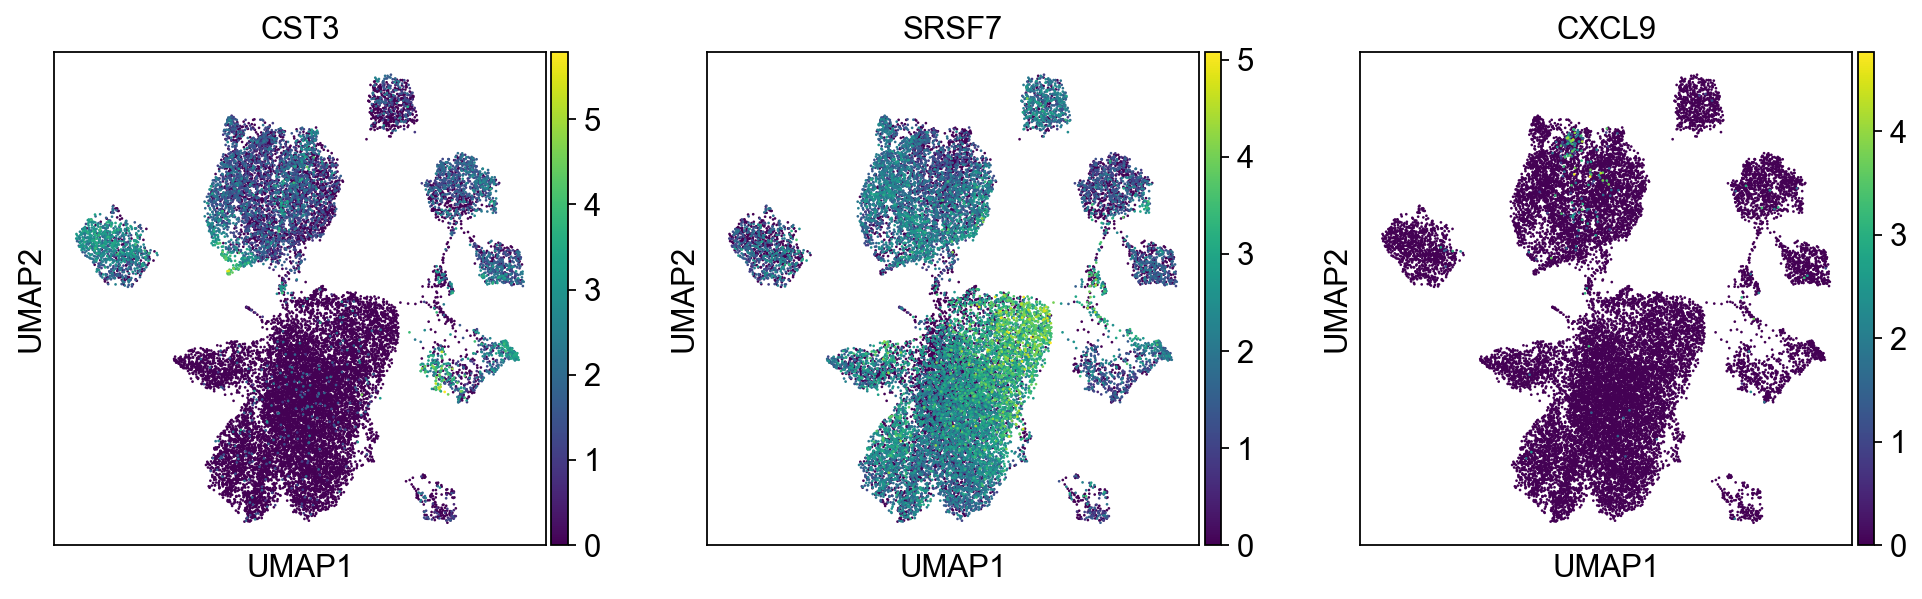

In [26]:
sc.pl.umap(adata, color=["CST3", "SRSF7", "CXCL9"])

/Users/andres/miniconda3/envs/scanpy/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:1234: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/Users/andres/miniconda3/envs/scanpy/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/Users/andres/miniconda3/envs/scanpy/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:1234: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(

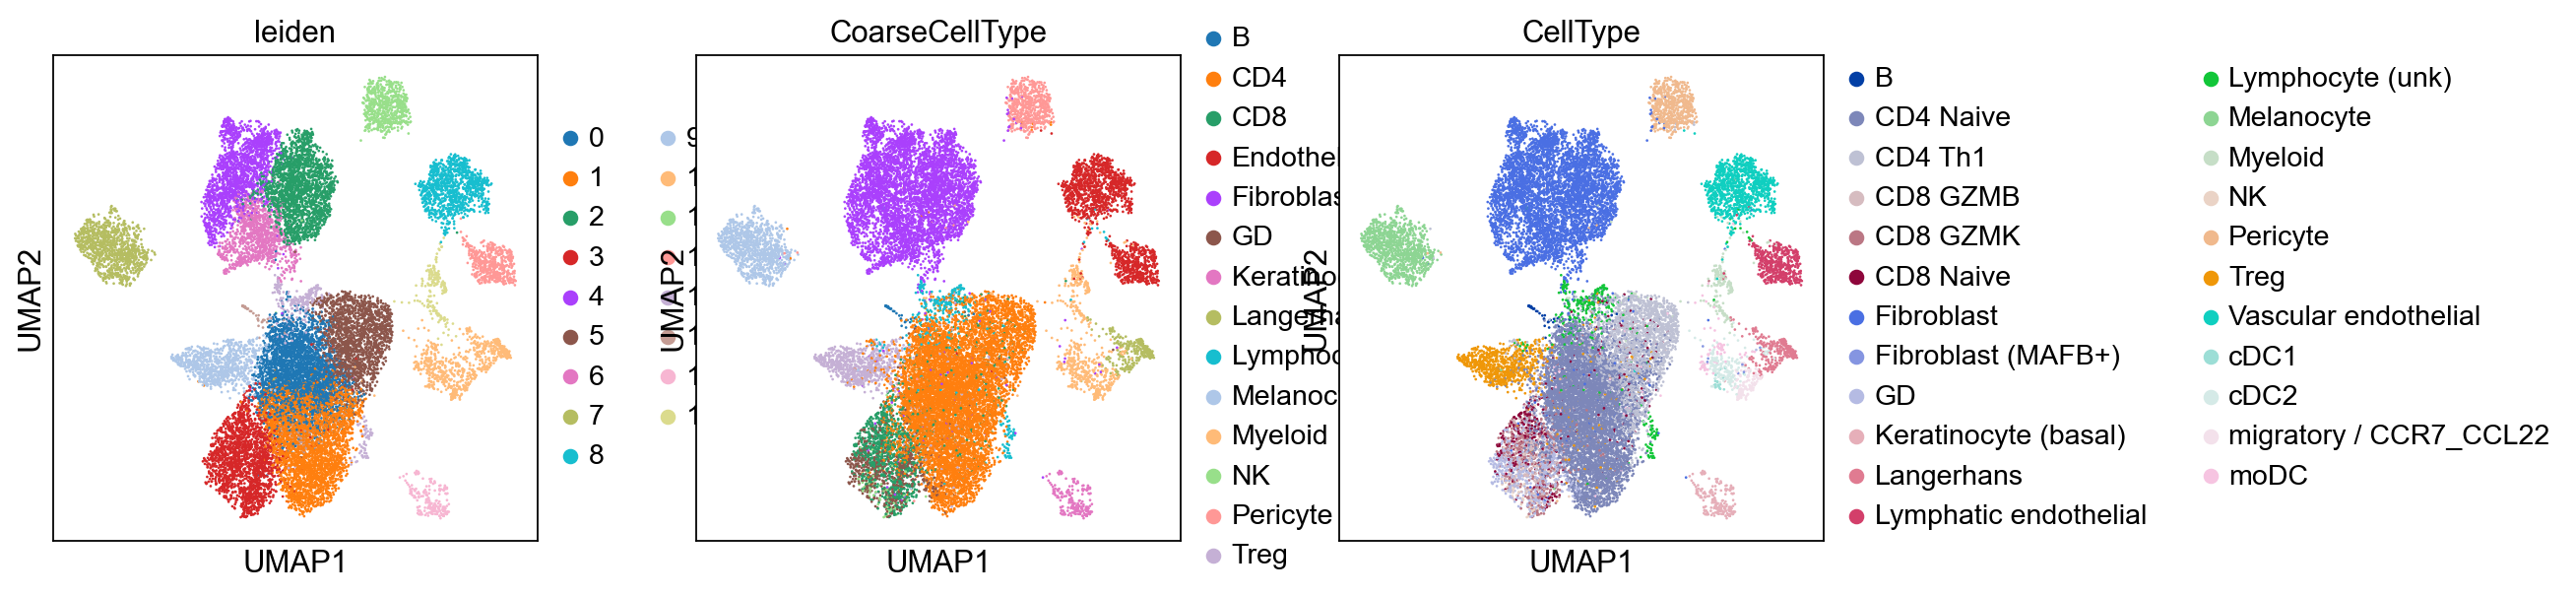

In [27]:
sc.pl.umap(adata, color=["leiden", "CoarseCellType", "CellType"])

ranking genes


/Users/andres/miniconda3/envs/scanpy/lib/python3.11/site-packages/numpy/core/fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:01:39)


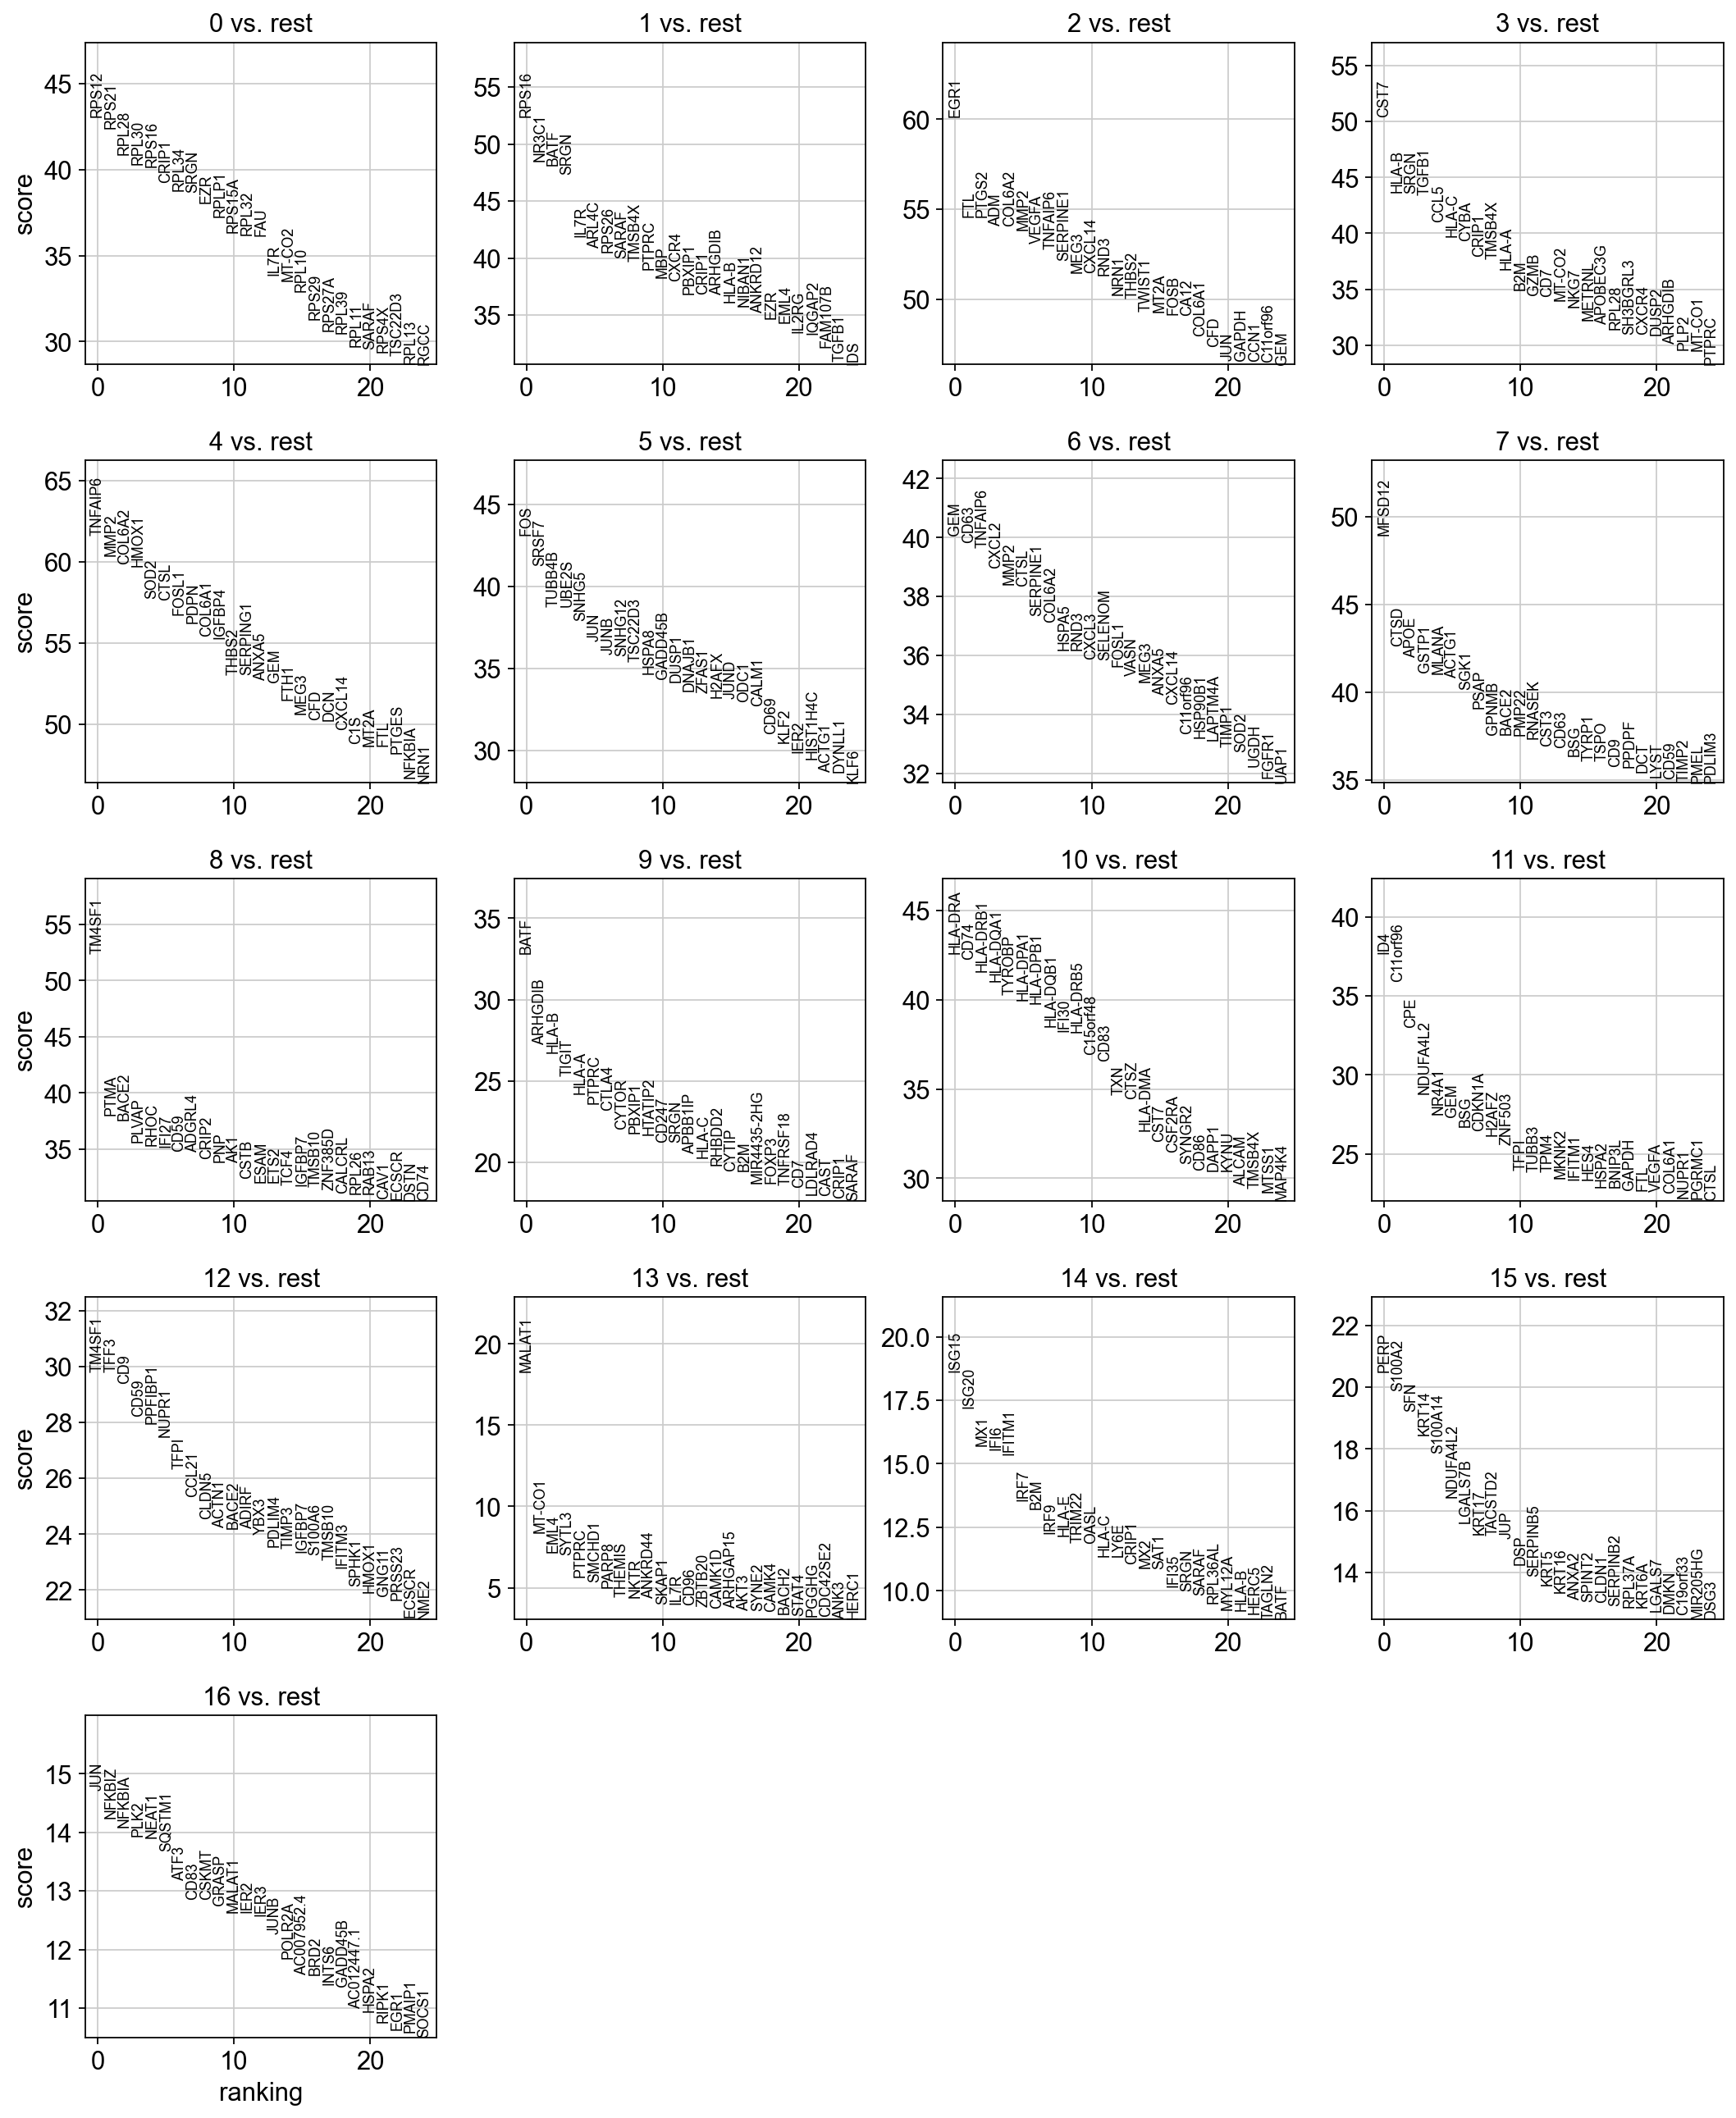

In [28]:
sc.tl.rank_genes_groups(adata, "leiden", method="wilcoxon")
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False)

In [29]:
df = pd.DataFrame(adata.uns["rank_genes_groups"]["names"])
df.head(5)

0      1       2      3        4       5        6       7       8  \
0  RPS12  RPS16    EGR1   CST7  TNFAIP6     FOS      GEM  MFSD12  TM4SF1   
1  RPS21  NR3C1     FTL  HLA-B     MMP2   SRSF7     CD63    CTSD    PTMA   
2  RPL28   BATF   PTGS2   SRGN   COL6A2  TUBB4B  TNFAIP6    APOE   BACE2   
3  RPL30   SRGN     ADM  TGFB1    HMOX1   UBE2S    CXCL2   GSTP1   PLVAP   
4  RPS16   IL7R  COL6A2   CCL5     SOD2   SNHG5     MMP2   MLANA    RHOC   

         9        10        11       12      13      14       15      16  
0     BATF   HLA-DRA       ID4   TM4SF1  MALAT1   ISG15     PERP     JUN  
1  ARHGDIB      CD74  C11orf96     TFF3  MT-CO1   ISG20   S100A2  NFKBIZ  
2    HLA-B  HLA-DRB1       CPE      CD9    EML4     MX1      SFN  NFKBIA  
3    TIGIT  HLA-DQA1  NDUFA4L2     CD59   SYTL3    IFI6    KRT14    PLK2  
4    HLA-A    TYROBP     NR4A1  PPFIBP1   PTPRC  IFITM1  S100A14   NEAT1

In [30]:
marker_genes = []
for col in df.columns:
    marker_genes += list(df[col][:5])
marker_genes = pd.unique(pd.Series(marker_genes)).tolist()
print(*marker_genes)

RPS12 RPS21 RPL28 RPL30 RPS16 NR3C1 BATF SRGN IL7R EGR1 FTL PTGS2 ADM COL6A2 CST7 HLA-B TGFB1 CCL5 TNFAIP6 MMP2 HMOX1 SOD2 FOS SRSF7 TUBB4B UBE2S SNHG5 GEM CD63 CXCL2 MFSD12 CTSD APOE GSTP1 MLANA TM4SF1 PTMA BACE2 PLVAP RHOC ARHGDIB TIGIT HLA-A HLA-DRA CD74 HLA-DRB1 HLA-DQA1 TYROBP ID4 C11orf96 CPE NDUFA4L2 NR4A1 TFF3 CD9 CD59 PPFIBP1 MALAT1 MT-CO1 EML4 SYTL3 PTPRC ISG15 ISG20 MX1 IFI6 IFITM1 PERP S100A2 SFN KRT14 S100A14 JUN NFKBIZ NFKBIA PLK2 NEAT1


In [31]:
result = adata.uns["rank_genes_groups"]
groups = result["names"].dtype.names
pd.DataFrame(
    {
        group + "_" + key[:1]: result[key][group]
        for group in groups
        for key in ["names", "pvals"]
    }
).head(5)

0_n  0_p    1_n  1_p     2_n  2_p    3_n  3_p      4_n  4_p  ...  \
0  RPS12  0.0  RPS16  0.0    EGR1  0.0   CST7  0.0  TNFAIP6  0.0  ...   
1  RPS21  0.0  NR3C1  0.0     FTL  0.0  HLA-B  0.0     MMP2  0.0  ...   
2  RPL28  0.0   BATF  0.0   PTGS2  0.0   SRGN  0.0   COL6A2  0.0  ...   
3  RPL30  0.0   SRGN  0.0     ADM  0.0  TGFB1  0.0    HMOX1  0.0  ...   
4  RPS16  0.0   IL7R  0.0  COL6A2  0.0   CCL5  0.0     SOD2  0.0  ...   

      12_n           12_p    13_n          13_p    14_n          14_p  \
0   TM4SF1  2.139366e-195  MALAT1  7.519653e-75   ISG15  1.607145e-77   
1     TFF3  2.249361e-195  MT-CO1  5.411880e-17   ISG20  2.649119e-66   
2      CD9  3.808666e-190    EML4  7.512658e-13     MX1  1.156730e-55   
3     CD59  2.454303e-175   SYTL3  1.833188e-12    IFI6  1.713775e-54   
4  PPFIBP1  4.527414e-172   PTPRC  1.236149e-08  IFITM1  2.530134e-53   

      15_n          15_p    16_n          16_p  
0     PERP  1.807078e-93     JUN  4.260642e-49  
1   S100A2  5.977083e-88  NFKBIZ  4.431199e-46  
2      SFN  1.969450e-82  NFKBIA  4.315383e-45  
3    KRT14  4.442392e-76    PLK2  3.702302e-44  
4  S100A14  2.444662e-71   NEAT1  5.857802e-44  

[5 rows x 34 columns]

In [32]:
adata

AnnData object with n_obs × n_vars = 20632 × 2810
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'hash.ID', 'stimulation', 'tissue', 'nCount_ADT', 'nFeature_ADT', 'nCount_HTO', 'nFeature_HTO', 'percent.mt', 'percent.rb', 'RNA_snn_res.0.01', 'RNA_snn_res.0.04', 'RNA_snn_res.0.08', 'RNA_snn_res.0.1', 'RNA_snn_res.0.14', 'RNA_snn_res.0.18', 'RNA_snn_res.0.2', 'RNA_snn_res.0.3', 'seurat_clusters', 'initial_celltypes', 'CellType', 'CoarseCellType', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'leiden'
    var: 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'log1p', 'hvg', 'pca', 'neighbors', 'leiden', 'paga', 'leiden_sizes', 'leiden_colors', 'umap', 'CoarseCellType_colors', 'CellType_colors', 'rank_genes_groups'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

/Users/andres/miniconda3/envs/scanpy/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:1234: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/Users/andres/miniconda3/envs/scanpy/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/Users/andres/miniconda3/envs/scanpy/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:1234: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(

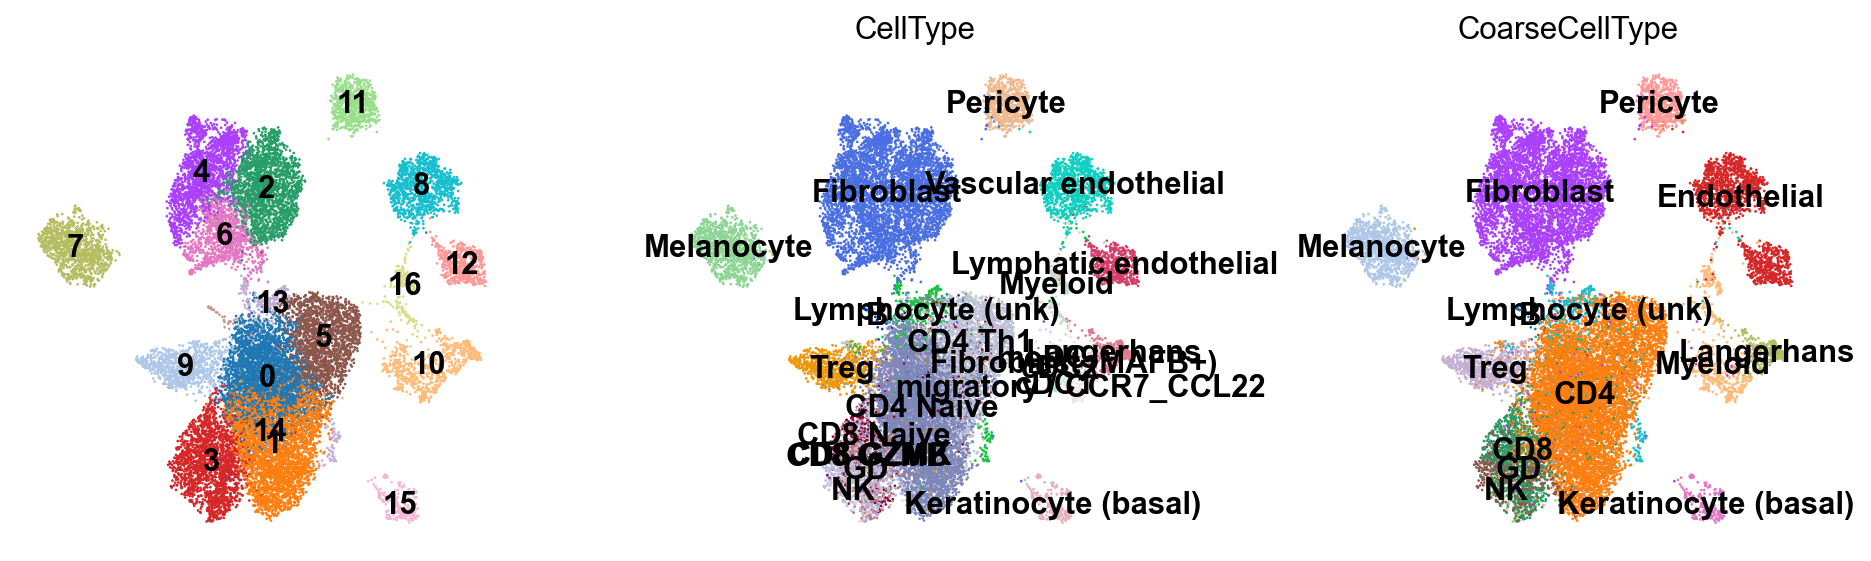

In [33]:
sc.pl.umap(adata, color=["leiden", "CellType", "CoarseCellType"], legend_loc="on data", title="", frameon=False)

/Users/andres/miniconda3/envs/scanpy/lib/python3.11/site-packages/scanpy/plotting/_dotplot.py:168: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  obs_bool.groupby(level=0).sum() / obs_bool.groupby(level=0).count()
/Users/andres/miniconda3/envs/scanpy/lib/python3.11/site-packages/scanpy/plotting/_dotplot.py:178: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  dot_color_df = self.obs_tidy.groupby(level=0).mean()
/Users/andres/miniconda3/envs/scanpy/lib/python3.11/site-packages/scanpy/plotting/_dotplot.py:747: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax

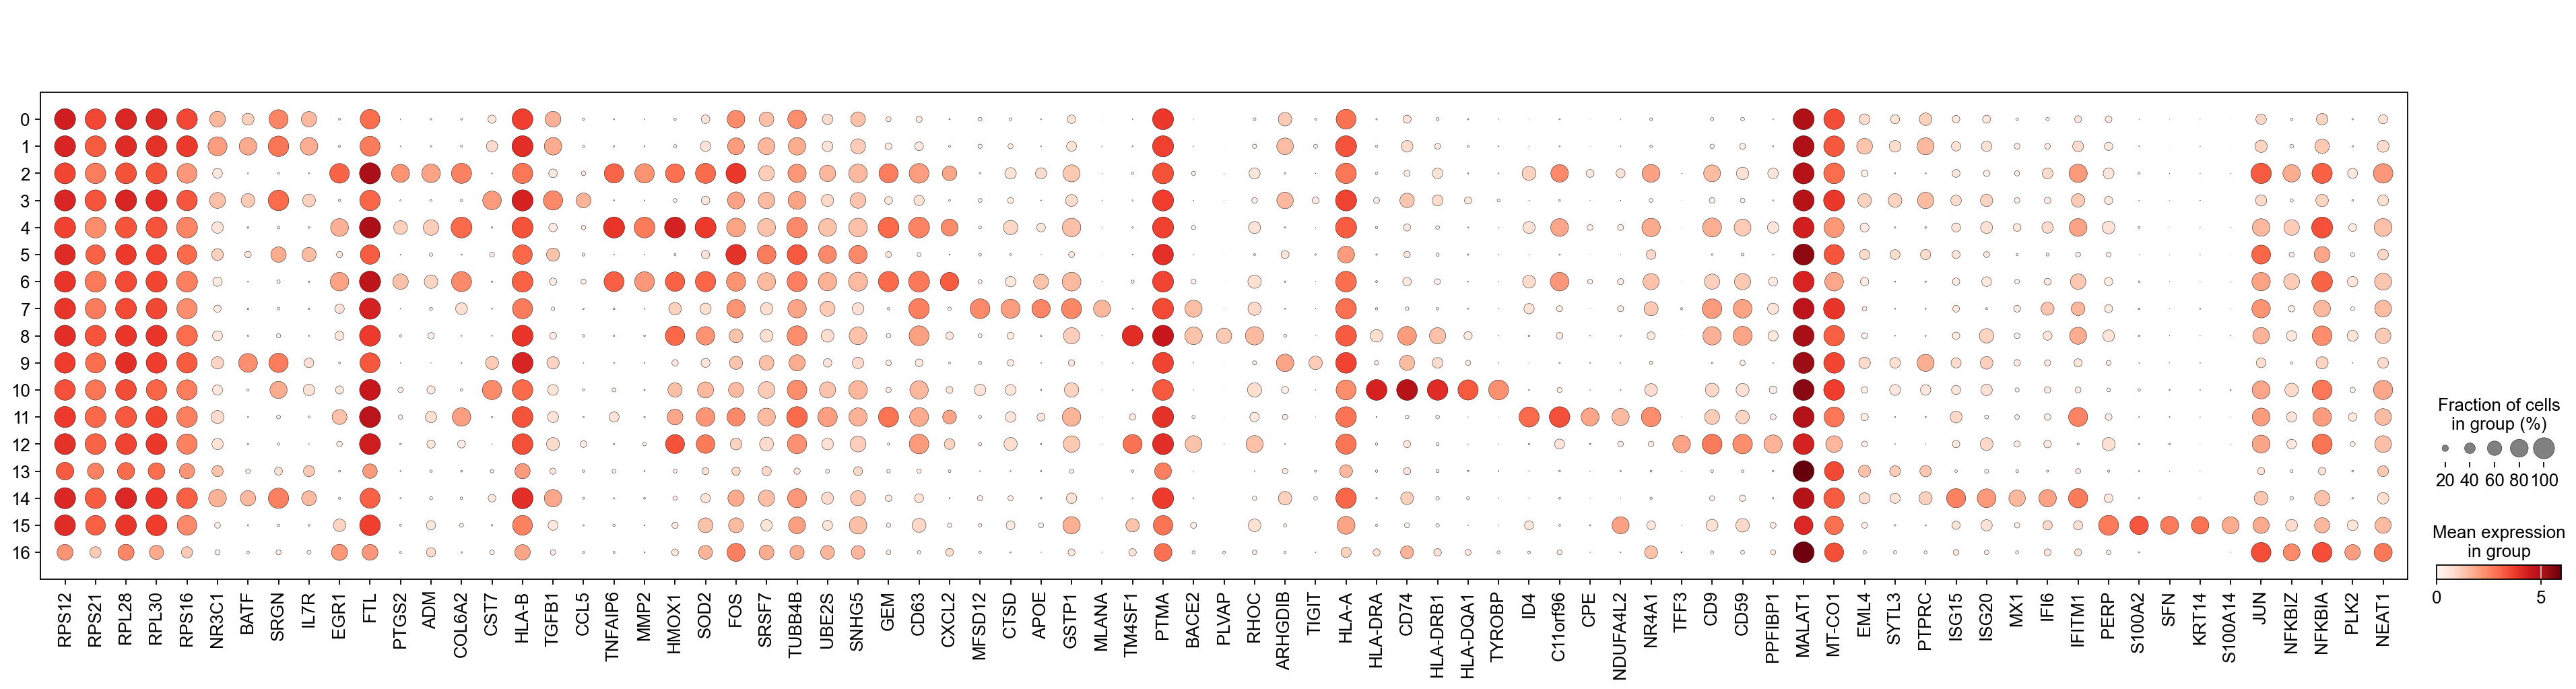

In [34]:
sc.pl.dotplot(adata, marker_genes, groupby="leiden")

/Users/andres/miniconda3/envs/scanpy/lib/python3.11/site-packages/scanpy/plotting/_dotplot.py:168: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  obs_bool.groupby(level=0).sum() / obs_bool.groupby(level=0).count()
/Users/andres/miniconda3/envs/scanpy/lib/python3.11/site-packages/scanpy/plotting/_dotplot.py:178: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  dot_color_df = self.obs_tidy.groupby(level=0).mean()
/Users/andres/miniconda3/envs/scanpy/lib/python3.11/site-packages/scanpy/plotting/_dotplot.py:747: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax

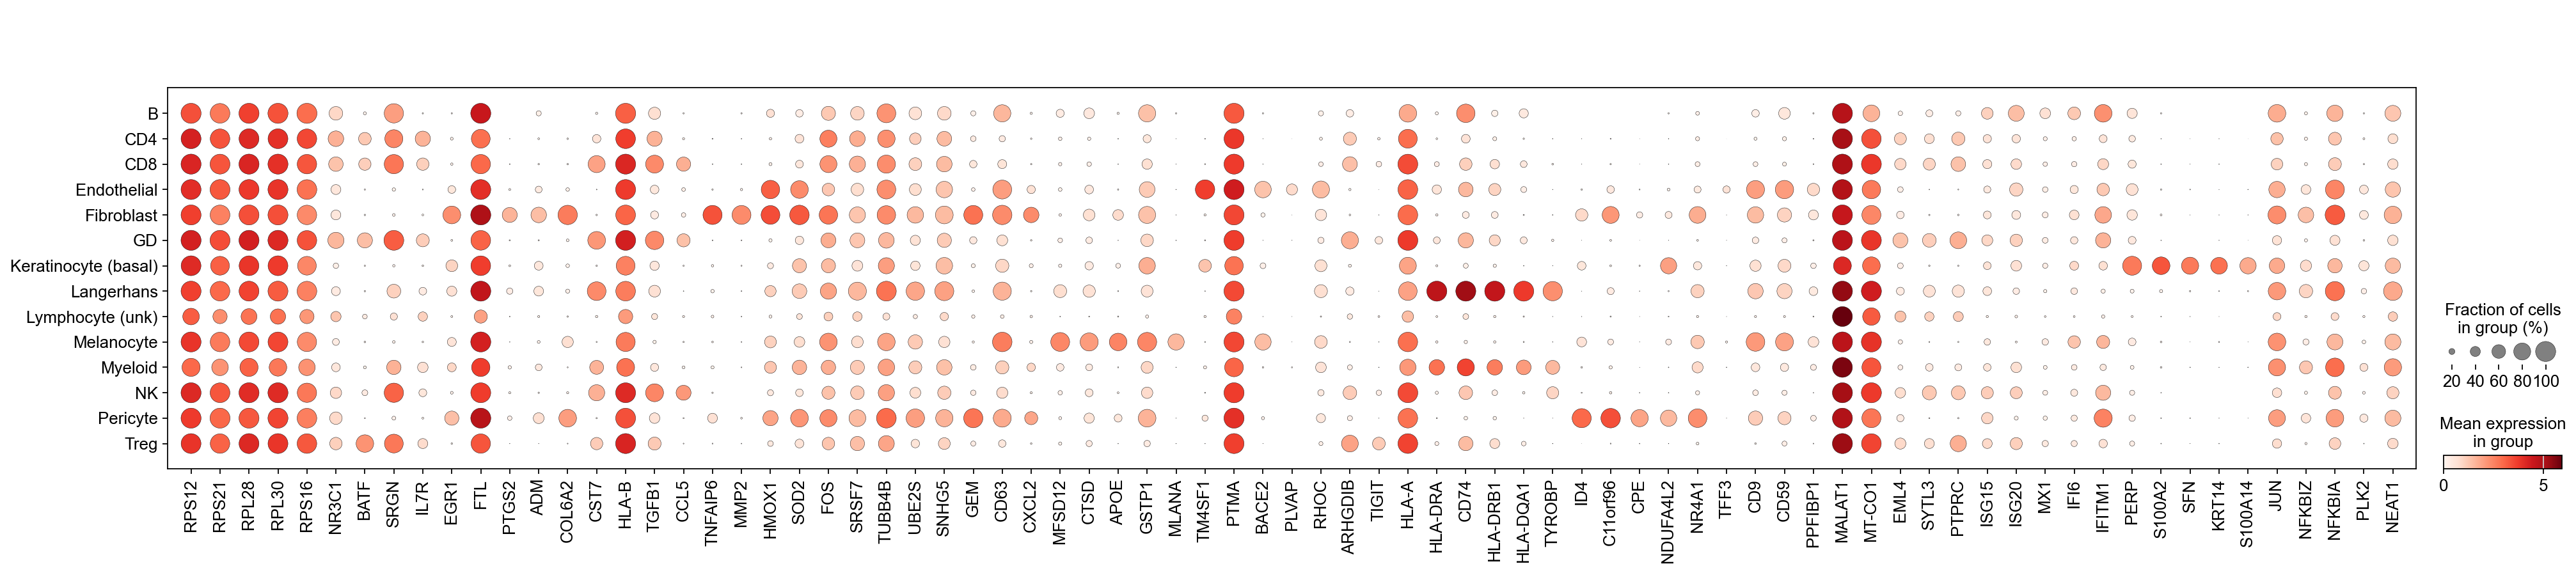

In [35]:
sc.pl.dotplot(adata, marker_genes, groupby="CoarseCellType")

/Users/andres/miniconda3/envs/scanpy/lib/python3.11/site-packages/scanpy/plotting/_dotplot.py:168: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  obs_bool.groupby(level=0).sum() / obs_bool.groupby(level=0).count()
/Users/andres/miniconda3/envs/scanpy/lib/python3.11/site-packages/scanpy/plotting/_dotplot.py:178: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  dot_color_df = self.obs_tidy.groupby(level=0).mean()
/Users/andres/miniconda3/envs/scanpy/lib/python3.11/site-packages/scanpy/plotting/_dotplot.py:747: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax

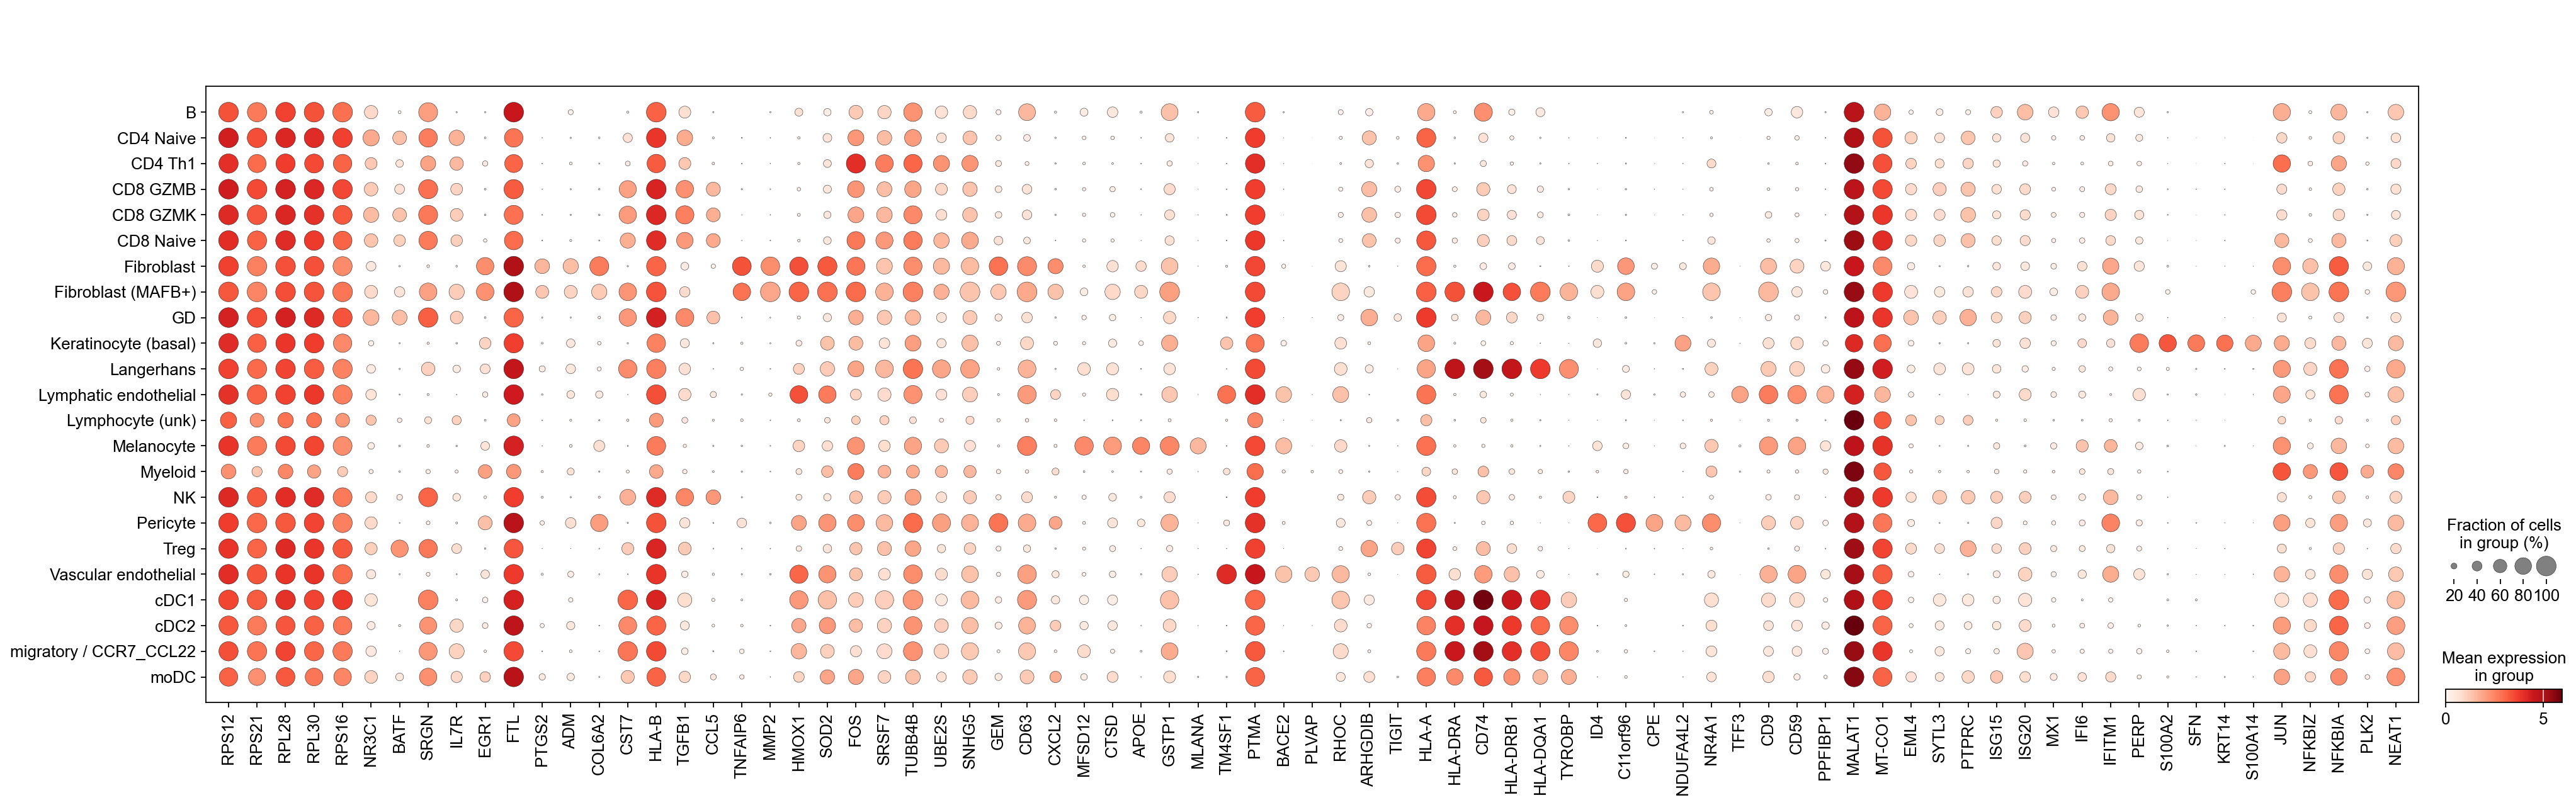

In [36]:
sc.pl.dotplot(adata, marker_genes, groupby="CellType")

In [37]:
marker_genes_orig = ["IL6", "CXCL8", "CXCL11", "CXCL2", "CCL5", "CCL2"]

/Users/andres/miniconda3/envs/scanpy/lib/python3.11/site-packages/scanpy/plotting/_dotplot.py:168: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  obs_bool.groupby(level=0).sum() / obs_bool.groupby(level=0).count()
/Users/andres/miniconda3/envs/scanpy/lib/python3.11/site-packages/scanpy/plotting/_dotplot.py:178: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  dot_color_df = self.obs_tidy.groupby(level=0).mean()
/Users/andres/miniconda3/envs/scanpy/lib/python3.11/site-packages/scanpy/plotting/_dotplot.py:747: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax

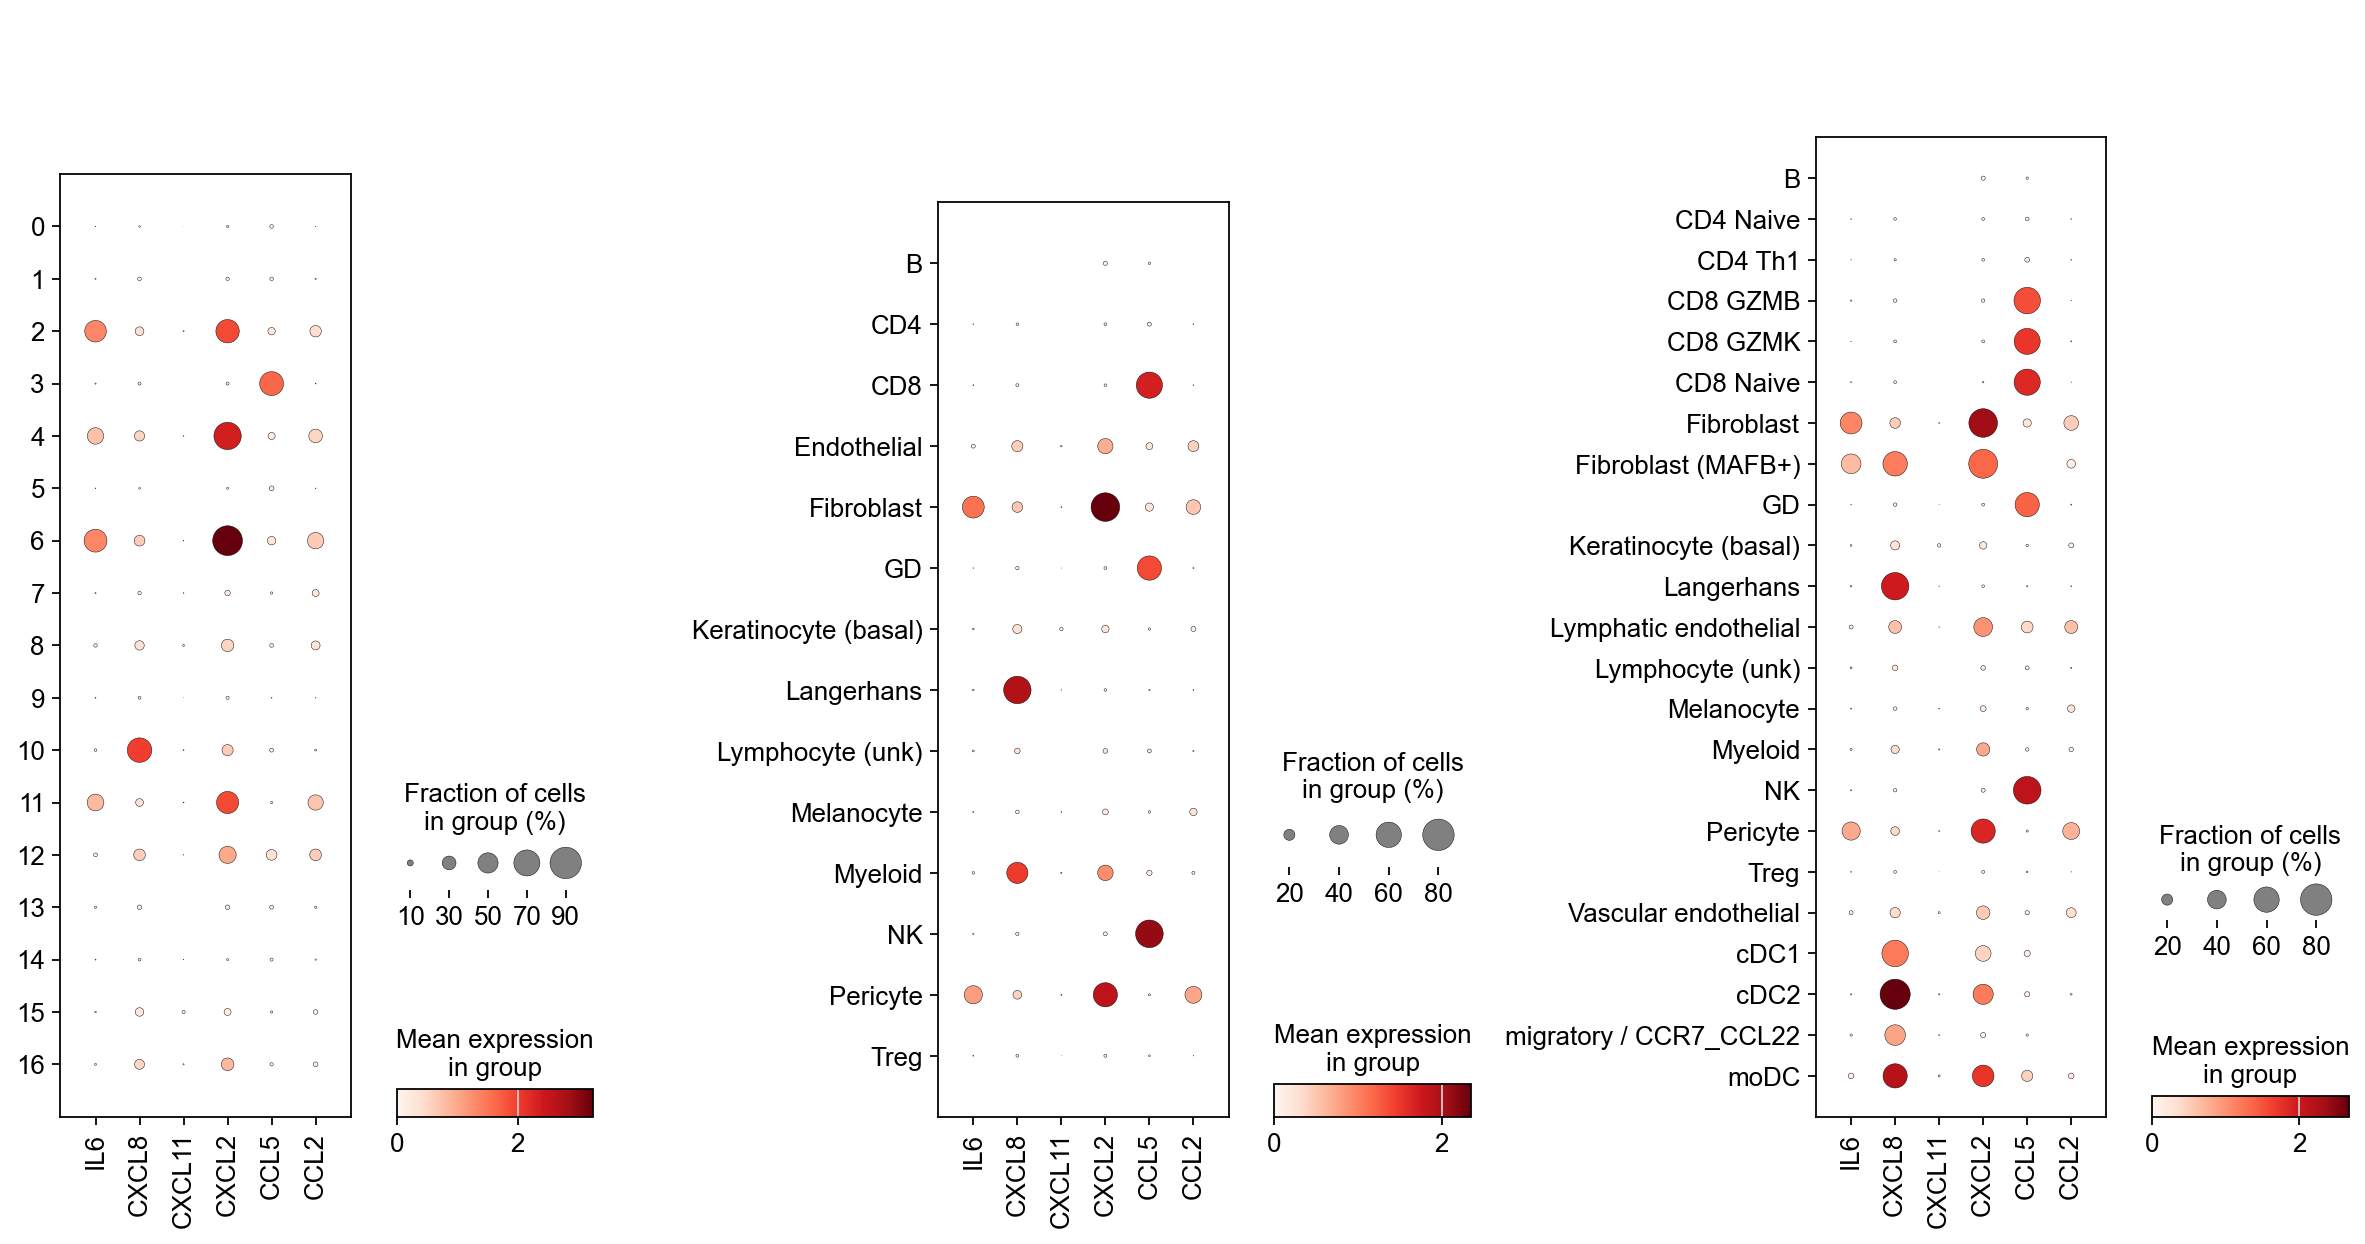

In [38]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 3, figsize=(15, 8)) 

sc.pl.dotplot(adata, marker_genes_orig, groupby="leiden", ax=axs[0], show=False)
sc.pl.dotplot(adata, marker_genes_orig, groupby="CoarseCellType", ax=axs[1], show=False)
sc.pl.dotplot(adata, marker_genes_orig, groupby="CellType", ax=axs[2], show=False)

plt.tight_layout()
plt.show()

In [39]:
adata

AnnData object with n_obs × n_vars = 20632 × 2810
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'hash.ID', 'stimulation', 'tissue', 'nCount_ADT', 'nFeature_ADT', 'nCount_HTO', 'nFeature_HTO', 'percent.mt', 'percent.rb', 'RNA_snn_res.0.01', 'RNA_snn_res.0.04', 'RNA_snn_res.0.08', 'RNA_snn_res.0.1', 'RNA_snn_res.0.14', 'RNA_snn_res.0.18', 'RNA_snn_res.0.2', 'RNA_snn_res.0.3', 'seurat_clusters', 'initial_celltypes', 'CellType', 'CoarseCellType', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'leiden'
    var: 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'log1p', 'hvg', 'pca', 'neighbors', 'leiden', 'paga', 'leiden_sizes', 'leiden_colors', 'umap', 'CoarseCellType_colors', 'CellType_colors', 'rank_genes_groups'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

In [40]:
adata.write("data/5_annotation_res0.2_subclustered_scanpy_analysis.h5ad", compression="gzip")